In [ ]:
! pip install neuraloperator

In [3]:
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset

from neuralop.data.datasets import DarcyDataset, load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.losses.data_losses import LpLoss
from neuralop.training import Trainer
from neuralop.models import FNO

device = 'cpu'

In [4]:
import matplotlib.pyplot as plt

def visualize_pair(x_all, y_all, idx):
    """
    Plot x_all[idx] and y_all[idx] side by side.

    Parameters
    ----------
    x_all : torch.Tensor or np.ndarray, shape (N, 16, 16)
    y_all : torch.Tensor or np.ndarray, shape (N, 16, 16)
    idx   : int, which sample to plot

    Displays a matplotlib figure.
    """
    # if torch.Tensor, convert to numpy
    if hasattr(x_all, 'cpu'):
        x = x_all[idx].cpu().numpy()
    else:
        x = x_all[idx]
    if hasattr(y_all, 'cpu'):
        y = y_all[idx].cpu().numpy()
    else:
        y = y_all[idx]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(x, aspect='equal')
    axes[0].set_title(f'x_all[{idx}]')
    axes[0].axis('off')

    axes[1].imshow(y, aspect='equal')
    axes[1].set_title(f'y_all[{idx}]')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Load Darcy Flow Dataset

In [5]:
ds16 = DarcyDataset(root_dir="./data", n_train=5000, n_tests=[1000, 500],
                 batch_size=32, test_batch_sizes=[32, 32],
                 train_resolution=16,
                 test_resolutions=[16,32],download=True)

Loading test db for resolution 16 with 1000 samples 
Loading test db for resolution 32 with 500 samples 


In [6]:
ds32 = DarcyDataset(root_dir="./data", n_train=5000, n_tests=[1000, 500],
                 batch_size=32, test_batch_sizes=[32, 32],
                 train_resolution=32,
                 test_resolutions=[16,32],download=True)

Loading test db for resolution 16 with 1000 samples 
Loading test db for resolution 32 with 500 samples 


In [7]:
a = ds16.train_db
full_loader = DataLoader(a,
                         batch_size=len(a),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
# batch is a dict, so:
x_all_16 = batch['x']
y_all_16 = batch['y']
x_all_16 = x_all_16.squeeze(1)
y_all_16 = y_all_16.squeeze(1)
print(x_all_16.shape)
print(y_all_16.shape)

torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])


In [8]:
a = ds32.train_db

full_loader = DataLoader(a,
                         batch_size=len(a),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
# batch is a dict, so:
x_all_32 = batch['x']
y_all_32 = batch['y']
x_train_32_16 = F.interpolate(x_all_32, size=(16, 16), mode='bilinear', align_corners=False)
x_all_32 = x_all_32.squeeze(1)
y_all_32 = y_all_32.squeeze(1)
x_train_32_16 = x_train_32_16.squeeze(1)
print(x_train_32_16.shape)
print(x_all_32.shape)
print(y_all_32.shape)

torch.Size([5000, 16, 16])
torch.Size([5000, 32, 32])
torch.Size([5000, 32, 32])


In [9]:
b = ds16.test_dbs[16]
full_loader = DataLoader(b,
                         batch_size=len(b),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
x_all_test_16 = batch['x']
y_all_test_16 = batch['y']
x_all_test_16 = x_all_test_16.squeeze(1)
y_all_test_16 = y_all_test_16.squeeze(1)
print(x_all_test_16.shape)
print(y_all_test_16.shape)

torch.Size([50, 16, 16])
torch.Size([50, 16, 16])


In [37]:
b = ds16.test_dbs[32]
full_loader = DataLoader(b,
                         batch_size=len(b),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
x_all_test_32 = batch['x']
y_all_test_32 = batch['y']
x_test_32_16 = F.interpolate(x_all_test_32, size=(16, 16), mode='bilinear', align_corners=False)
x_all_test_32 = x_all_test_32.squeeze(1)
y_all_test_32 = y_all_test_32.squeeze(1)
x_test_32_16 = x_test_32_16.squeeze(1)
print(x_all_test_32.shape)
print(y_all_test_32.shape)
print(x_test_32_16.shape)

torch.Size([500, 32, 32])
torch.Size([500, 32, 32])
torch.Size([500, 16, 16])


In [38]:
# Wrap x/y tensors in a dict-style dataset
class DictDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.unsqueeze(1)  # [B, 1, H, W]
        self.y = y.unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

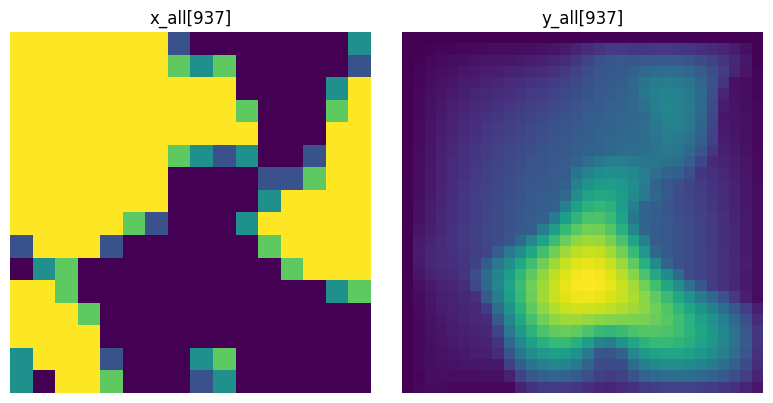

In [39]:
visualize_pair(x_train_32_16, y_all_32, idx=937)

# Define FNO Model

In [13]:
class FNOWithUpsample(nn.Module):
    def __init__(self, base_fno):
        super().__init__()
        self.fno = base_fno
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        """
        x: [B, 1, H, W] — input of size 16x16 or 32x32
        """
        out = self.fno(x)  # shape: [B, 1, H, W]
        if out.shape[-1] == 16:
            out = self.upsample(out)

        return out

In [14]:
def train_fno_model(model,
                    dataset,
                    num_epochs=100,
                    batch_size=32,
                    lr=1e-3,
                    val_split=0.1,
                    device="cuda" if torch.cuda.is_available() else "cpu"):

    # Split into training and validation sets
    N = len(dataset)
    n_val = int(N * val_split)
    n_train = N - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val = float('inf')
    best_state = None

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)

        for i, (x, y) in enumerate(train_bar):
            x, y = x.to(device), y.to(device)

            # Downsample input to 16x16
            x_down = nn.functional.interpolate(x, size=(16, 16), mode='bilinear', align_corners=False)

            optimizer.zero_grad()
            pred = model(x_down)  # model should return [B,1,32,32] via internal upsampling
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=f"{train_loss / (i + 1):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                x_down = nn.functional.interpolate(x, size=(16, 16), mode='bilinear', align_corners=False)
                pred = model(x_down)
                val_loss += criterion(pred, y).item()

        avg_val = val_loss / max(len(val_loader), 1)
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {avg_val:.6f}")

        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
            print(f" → New best model (Val Loss = {best_val:.6f})")

    if best_state is not None:
        if '_metadata' in best_state:
          del best_state['_metadata']
        model.load_state_dict(best_state)

    return model.to("cpu")

In [15]:
dataset_fno = DictDataset(x_train_32_16, y_all_32)

base_fno = FNO(
    n_modes=(12, 12),         # Fourier modes per spatial dimension
    hidden_channels=32,       # Width of hidden layers
    in_channels=1,            # Input: Darcy coeff (1 channel)
    out_channels=1,           # Output: Darcy solution (1 channel)
    num_layers=4,             # Number of Fourier layers
    use_mlp=True              # Use MLP projection at the end
)

# Step 2: Wrap it with the upsampling head
model = FNOWithUpsample(base_fno)

best_model = train_fno_model(
    model,
    dataset_fno,
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    val_split=0.1
)

Epoch   1 | Train Loss: 0.088045 | Val Loss: 0.017470
 → New best model (Val Loss = 0.017470)


Epoch   2 | Train Loss: 0.010561 | Val Loss: 0.007228
 → New best model (Val Loss = 0.007228)


Epoch   3 | Train Loss: 0.005591 | Val Loss: 0.004580
 → New best model (Val Loss = 0.004580)


Epoch   4 | Train Loss: 0.004119 | Val Loss: 0.003547
 → New best model (Val Loss = 0.003547)


Epoch   5 | Train Loss: 0.003127 | Val Loss: 0.003449
 → New best model (Val Loss = 0.003449)


Epoch   6 | Train Loss: 0.002495 | Val Loss: 0.002721
 → New best model (Val Loss = 0.002721)


Epoch   7 | Train Loss: 0.002042 | Val Loss: 0.002354
 → New best model (Val Loss = 0.002354)


Epoch   8 | Train Loss: 0.001740 | Val Loss: 0.002132
 → New best model (Val Loss = 0.002132)


Epoch   9 | Train Loss: 0.001571 | Val Loss: 0.002080
 → New best model (Val Loss = 0.002080)


Epoch  10 | Train Loss: 0.001378 | Val Loss: 0.002057
 → New best model (Val Loss = 0.002057)


Epoch  11 | Train Loss: 0.001204 | Val Loss: 0.001853
 → New best model (Val Loss = 0.001853)


Epoch  12 | Train Loss: 0.001133 | Val Loss: 0.001756
 → New best model (Val Loss = 0.001756)


Epoch  13 | Train Loss: 0.001058 | Val Loss: 0.001725
 → New best model (Val Loss = 0.001725)


Epoch  14 | Train Loss: 0.000951 | Val Loss: 0.001674
 → New best model (Val Loss = 0.001674)


Epoch  15 | Train Loss: 0.000887 | Val Loss: 0.001584
 → New best model (Val Loss = 0.001584)


Epoch  16 | Train Loss: 0.000859 | Val Loss: 0.001681


Epoch  17 | Train Loss: 0.000821 | Val Loss: 0.001760


Epoch  18 | Train Loss: 0.000771 | Val Loss: 0.001528
 → New best model (Val Loss = 0.001528)


Epoch  19 | Train Loss: 0.000754 | Val Loss: 0.001510
 → New best model (Val Loss = 0.001510)


Epoch  20 | Train Loss: 0.000740 | Val Loss: 0.001481
 → New best model (Val Loss = 0.001481)


Epoch  21 | Train Loss: 0.000711 | Val Loss: 0.001470
 → New best model (Val Loss = 0.001470)


Epoch  22 | Train Loss: 0.000877 | Val Loss: 0.001662


Epoch  23 | Train Loss: 0.000674 | Val Loss: 0.001449
 → New best model (Val Loss = 0.001449)


Epoch  24 | Train Loss: 0.000660 | Val Loss: 0.001435
 → New best model (Val Loss = 0.001435)


Epoch  25 | Train Loss: 0.000605 | Val Loss: 0.001492


Epoch  26 | Train Loss: 0.000616 | Val Loss: 0.001365
 → New best model (Val Loss = 0.001365)


Epoch  27 | Train Loss: 0.000596 | Val Loss: 0.001400


Epoch  28 | Train Loss: 0.000591 | Val Loss: 0.001509


Epoch  29 | Train Loss: 0.000641 | Val Loss: 0.001337
 → New best model (Val Loss = 0.001337)


Epoch  30 | Train Loss: 0.000584 | Val Loss: 0.001348


Epoch  31 | Train Loss: 0.000576 | Val Loss: 0.001482


Epoch  32 | Train Loss: 0.000548 | Val Loss: 0.001318
 → New best model (Val Loss = 0.001318)


Epoch  33 | Train Loss: 0.000541 | Val Loss: 0.001315
 → New best model (Val Loss = 0.001315)


Epoch  34 | Train Loss: 0.000545 | Val Loss: 0.001300
 → New best model (Val Loss = 0.001300)


Epoch  35 | Train Loss: 0.000609 | Val Loss: 0.001706


Epoch  36 | Train Loss: 0.000598 | Val Loss: 0.001385


Epoch  37 | Train Loss: 0.000537 | Val Loss: 0.001376


Epoch  38 | Train Loss: 0.000511 | Val Loss: 0.001327


Epoch  39 | Train Loss: 0.000514 | Val Loss: 0.001288
 → New best model (Val Loss = 0.001288)


Epoch  40 | Train Loss: 0.000489 | Val Loss: 0.001348


Epoch  41 | Train Loss: 0.000639 | Val Loss: 0.001457


Epoch  42 | Train Loss: 0.000575 | Val Loss: 0.001315


Epoch  43 | Train Loss: 0.000494 | Val Loss: 0.001388


Epoch  44 | Train Loss: 0.000468 | Val Loss: 0.001268
 → New best model (Val Loss = 0.001268)


Epoch  45 | Train Loss: 0.000475 | Val Loss: 0.001282


Epoch  46 | Train Loss: 0.000461 | Val Loss: 0.001267
 → New best model (Val Loss = 0.001267)


Epoch  47 | Train Loss: 0.000438 | Val Loss: 0.001271


Epoch  48 | Train Loss: 0.000438 | Val Loss: 0.001287


Epoch  49 | Train Loss: 0.000435 | Val Loss: 0.001222
 → New best model (Val Loss = 0.001222)


Epoch  50 | Train Loss: 0.000444 | Val Loss: 0.001231


Epoch  51 | Train Loss: 0.000442 | Val Loss: 0.001293


Epoch  52 | Train Loss: 0.000501 | Val Loss: 0.001234


Epoch  53 | Train Loss: 0.000474 | Val Loss: 0.001274


Epoch  54 | Train Loss: 0.000458 | Val Loss: 0.001320


Epoch  55 | Train Loss: 0.000506 | Val Loss: 0.001223


Epoch  56 | Train Loss: 0.000469 | Val Loss: 0.001176
 → New best model (Val Loss = 0.001176)


Epoch  57 | Train Loss: 0.000498 | Val Loss: 0.001342


Epoch  58 | Train Loss: 0.000469 | Val Loss: 0.001245


Epoch  59 | Train Loss: 0.000419 | Val Loss: 0.001189


Epoch  60 | Train Loss: 0.000404 | Val Loss: 0.001241


Epoch  61 | Train Loss: 0.000392 | Val Loss: 0.001209


Epoch  62 | Train Loss: 0.000381 | Val Loss: 0.001181


Epoch  63 | Train Loss: 0.000403 | Val Loss: 0.001261


Epoch  64 | Train Loss: 0.000405 | Val Loss: 0.001198


Epoch  65 | Train Loss: 0.000427 | Val Loss: 0.001212


Epoch  66 | Train Loss: 0.000434 | Val Loss: 0.001170
 → New best model (Val Loss = 0.001170)


Epoch  67 | Train Loss: 0.000438 | Val Loss: 0.001193


Epoch  68 | Train Loss: 0.000393 | Val Loss: 0.001285


Epoch  69 | Train Loss: 0.000391 | Val Loss: 0.001174


Epoch  70 | Train Loss: 0.000394 | Val Loss: 0.001135
 → New best model (Val Loss = 0.001135)


Epoch  71 | Train Loss: 0.000407 | Val Loss: 0.001232


Epoch  72 | Train Loss: 0.000416 | Val Loss: 0.001166


Epoch  73 | Train Loss: 0.000405 | Val Loss: 0.001330


Epoch  74 | Train Loss: 0.000389 | Val Loss: 0.001178


Epoch  75 | Train Loss: 0.000382 | Val Loss: 0.001159


Epoch  76 | Train Loss: 0.000397 | Val Loss: 0.001305


Epoch  77 | Train Loss: 0.000382 | Val Loss: 0.001184


Epoch  78 | Train Loss: 0.000389 | Val Loss: 0.001156


Epoch  79 | Train Loss: 0.000379 | Val Loss: 0.001221


Epoch  80 | Train Loss: 0.000380 | Val Loss: 0.001225


Epoch  81 | Train Loss: 0.000399 | Val Loss: 0.001131
 → New best model (Val Loss = 0.001131)


Epoch  82 | Train Loss: 0.000359 | Val Loss: 0.001139


Epoch  83 | Train Loss: 0.000365 | Val Loss: 0.001184


Epoch  84 | Train Loss: 0.000365 | Val Loss: 0.001221


Epoch  85 | Train Loss: 0.000389 | Val Loss: 0.001153


Epoch  86 | Train Loss: 0.000358 | Val Loss: 0.001186


Epoch  87 | Train Loss: 0.000379 | Val Loss: 0.001184


Epoch  88 | Train Loss: 0.000426 | Val Loss: 0.001156


Epoch  89 | Train Loss: 0.000361 | Val Loss: 0.001430


Epoch  90 | Train Loss: 0.000379 | Val Loss: 0.001555


Epoch  91 | Train Loss: 0.000344 | Val Loss: 0.001201


Epoch  92 | Train Loss: 0.000327 | Val Loss: 0.001143


Epoch  93 | Train Loss: 0.000312 | Val Loss: 0.001148


Epoch  94 | Train Loss: 0.000311 | Val Loss: 0.001121
 → New best model (Val Loss = 0.001121)


Epoch  95 | Train Loss: 0.000350 | Val Loss: 0.001350


Epoch  96 | Train Loss: 0.000368 | Val Loss: 0.001154


Epoch  97 | Train Loss: 0.000340 | Val Loss: 0.001139


Epoch  98 | Train Loss: 0.000334 | Val Loss: 0.001118
 → New best model (Val Loss = 0.001118)


Epoch  99 | Train Loss: 0.000316 | Val Loss: 0.001109
 → New best model (Val Loss = 0.001109)


Epoch 100 | Train Loss: 0.000308 | Val Loss: 0.001130


# Plot Results

In [16]:
def run_and_plot(x_raw, y_raw, model, title, device="cpu"):
    """
    x_raw, y_raw: torch.Tensor shape [16,16]
    model: CPU model that maps x → y directly in spatial domain
    """
    # 1) Add batch and channel dimensions
    x = x_raw.unsqueeze(0).unsqueeze(0).to(device)
    y = y_raw.unsqueeze(0).unsqueeze(0).to(device)

    # 2) Run model
    model.eval()
    with torch.no_grad():
        y_pred = model(x)  # shape: [1,1,16,16]

    # 3) Remove batch and channel dims
    x = x.squeeze().cpu()       # [16,16]
    y = y.squeeze().cpu()       # [16,16]
    y_pred = y_pred.squeeze().cpu()  # [16,16]

    # 4) Plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x.numpy(), cmap='viridis'); axs[0].set_title(f"{title}: input x")
    axs[1].imshow(y.numpy(), cmap='viridis'); axs[1].set_title(f"{title}: true y")
    axs[2].imshow(y_pred.numpy(), cmap='viridis'); axs[2].set_title(f"{title}: predicted y")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

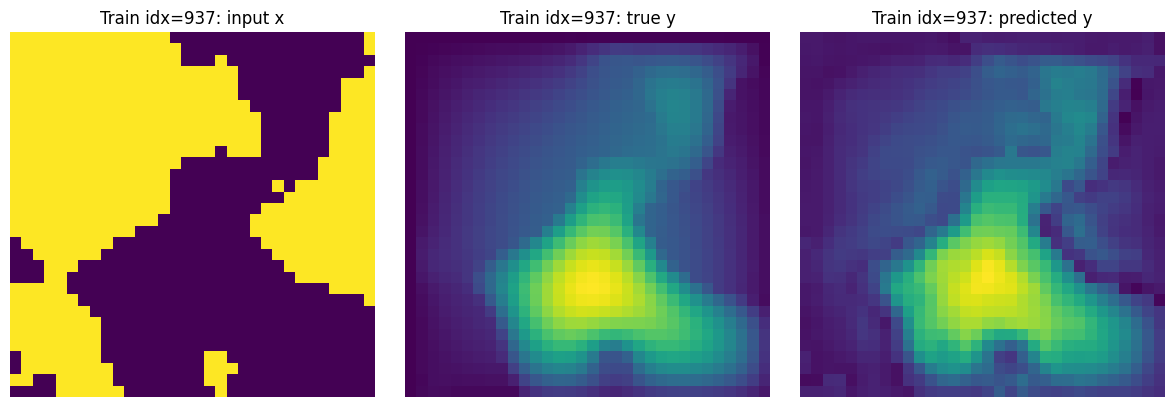

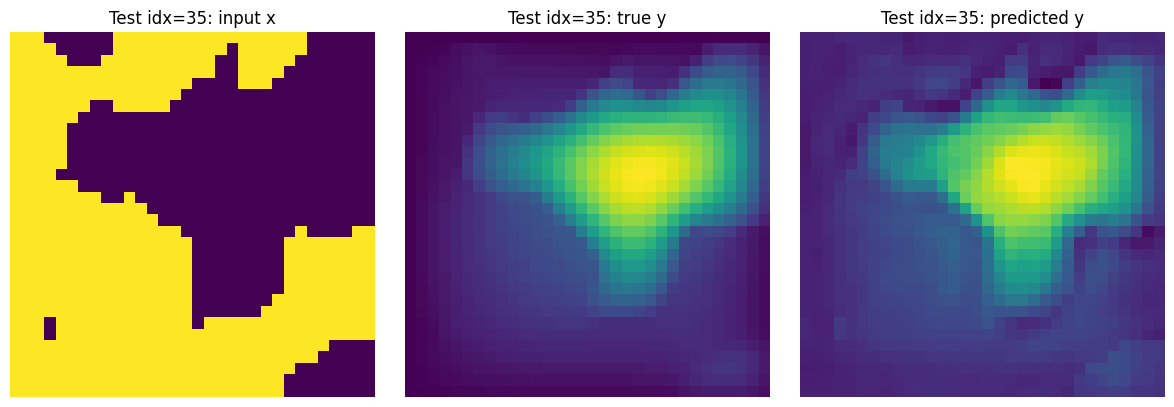

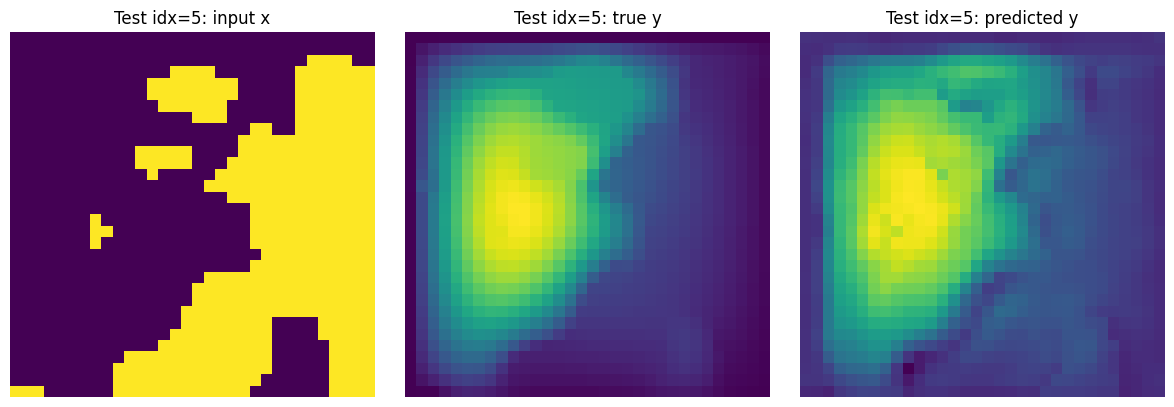

In [41]:
idx_train = 937
run_and_plot(x_all_32[idx_train], y_all_32[idx_train], best_model, f"Train idx={idx_train}")

idx_test = 35
run_and_plot(x_all_test_32[idx_test], y_all_test_32[idx_test], best_model, f"Test idx={idx_test}")

idx_test = 5
run_and_plot(x_all_test_32[idx_test], y_all_test_32[idx_test], best_model, f"Test idx={idx_test}")

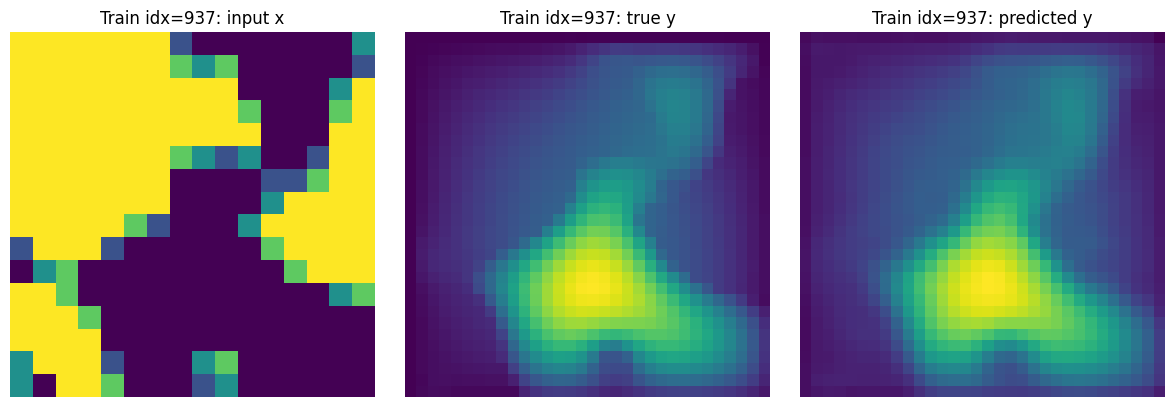

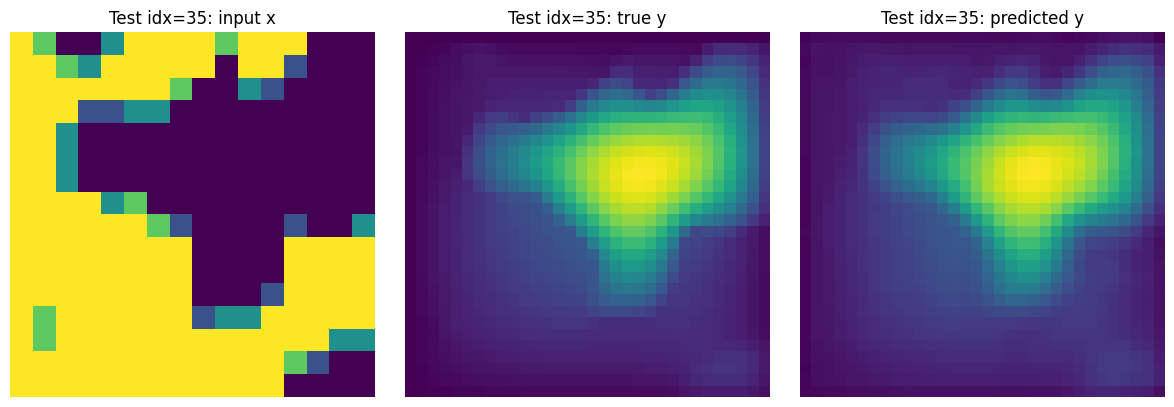

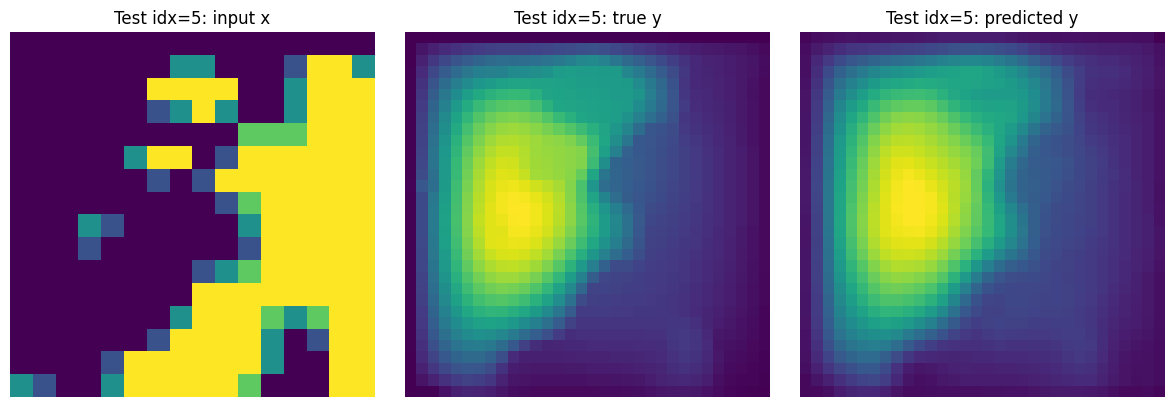

In [42]:
idx_train = 937
run_and_plot(x_train_32_16[idx_train], y_all_32[idx_train], best_model, f"Train idx={idx_train}")

idx_test = 35
run_and_plot(x_test_32_16[idx_test], y_all_test_32[idx_test], best_model, f"Test idx={idx_test}")

idx_test = 5
run_and_plot(x_test_32_16[idx_test], y_all_test_32[idx_test], best_model, f"Test idx={idx_test}")

In [24]:
def run_and_eval_rmse(x_raw, y_raw, model, device="cpu"):
    # Add channel dimension
    x = x_raw.unsqueeze(1).to(device)
    y = y_raw.unsqueeze(1).to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        y_pred = model(x)

    # Compute RMSE
    rmse = torch.sqrt(torch.mean((y_pred - y) ** 2)).item()
    return rmse

In [27]:
# get test loss
print(f"Test loss (Reconstruction): {run_and_eval_rmse(x_all_test_32, y_all_test_32, best_model):4f}")

Test loss (Reconstruction): 0.235591


In [28]:
print(f"Test loss (High-Res): {run_and_eval_rmse(x_test_32_16, y_all_test_32, best_model):4f}")

Test loss (High-Res): 0.031827


In [31]:
torch.save(best_model.state_dict(), "fno.pth")